In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
    
print("Using PyTorch verison : ", torch.__version__, 'Device: ', DEVICE)

Using PyTorch verison :  1.13.1+cpu Device:  cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.MNIST(root = '../data/MNIST', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = '../data/MNIST', train = False, transform = transforms.ToTensor())
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [5]:
for (X_train, y_train) in train_loader:
    print("X_train : ", X_train.size(), 'type :', X_train.type())
    print("y_train : ", y_train.size(), 'type :', y_train.type())
    break
    
## 32개의 이미지 데이터가 1개의 minibatch로 구성되어 있고, 그림은 28 x 28 로 구성되어 있음


X_train :  torch.Size([32, 1, 28, 28]) type : torch.FloatTensor
y_train :  torch.Size([32]) type : torch.LongTensor


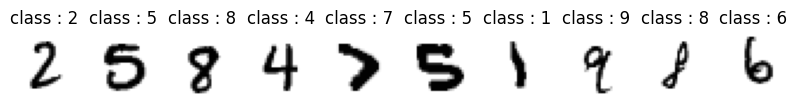

In [6]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis("off")
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = 'gray_r')
    plt.title("class : " + str(y_train[i].item()))

In [7]:
class Net(nn.Module):
    def __init__(self): #내가 사용할 layer 정의
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512 , 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x): # 내가 넣을 데이터는 x로 잡고 모델 구성시작.
        x = x.view(-1, 28 * 28)
        
        x = self.fc1(x)
        x - self.batch_norm1(x)        
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x
        

In [8]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [9]:
def train(model, train_loader ,optimizer, log_interval):
    model.train() # train 상태로 규정
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{}/{} ({:.0f}%)] \t Train Loss : {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset),
                 100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def evaluate(model, test_loader):
    model.eval() # 평가 상태로 규정
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy
    

In [11]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader ,optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n [EPOCH: {}], \t Test Loss : {:.4f}, \t Test Accuracy : {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/60000 (0%)] 	 Train Loss : 2.523865
Train Epoch : 1 [6400/60000 (11%)] 	 Train Loss : 0.469884
Train Epoch : 1 [12800/60000 (21%)] 	 Train Loss : 0.568219
Train Epoch : 1 [19200/60000 (32%)] 	 Train Loss : 0.297219
Train Epoch : 1 [25600/60000 (43%)] 	 Train Loss : 0.778881
Train Epoch : 1 [32000/60000 (53%)] 	 Train Loss : 0.765268
Train Epoch : 1 [38400/60000 (64%)] 	 Train Loss : 0.423084
Train Epoch : 1 [44800/60000 (75%)] 	 Train Loss : 0.064109
Train Epoch : 1 [51200/60000 (85%)] 	 Train Loss : 0.158214
Train Epoch : 1 [57600/60000 (96%)] 	 Train Loss : 0.127132

 [EPOCH: 1], 	 Test Loss : 0.0044, 	 Test Accuracy : 95.77 %

Train Epoch : 2 [0/60000 (0%)] 	 Train Loss : 0.199873
Train Epoch : 2 [6400/60000 (11%)] 	 Train Loss : 0.108626
Train Epoch : 2 [12800/60000 (21%)] 	 Train Loss : 0.133887
Train Epoch : 2 [19200/60000 (32%)] 	 Train Loss : 0.366411
Train Epoch : 2 [25600/60000 (43%)] 	 Train Loss : 0.163436
Train Epoch : 2 [32000/60000 (53%)] 	 Train Loss 